In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from clustering_comparison import *

In [56]:
M = loadmat('allpp.mat')['Z'][:,:]

In [153]:
plt.figure()
n = 6
n0 = 6

plt.subplot(2,6,n)
plt.imshow(np.reshape(M[:,5], (20,68), order="F"),cmap=)
plt.axis('off')
plt.subplot(2,6,n+n0)
plt.hist(M[:,5])

plt.subplot(2,6,n)
plt.imshow(np.reshape(M[:,4], (20,68), order="F"),cmap=)
plt.axis('off')

plt.subplot(2,6,n+n0)
plt.hist(M[:,5])


plt.subplot(2,6,n)
plt.imshow(np.reshape(M[:,3], (20,68), order="F"),cmap=)
plt.axis('off')

plt.subplot(2,6,n+n0)
plt.hist(M[:,5])


plt.subplot(2,6,n)
plt.imshow(np.reshape(M[:,2], (20,68), order="F"),cmap=)
plt.axis('off')

plt.subplot(2,6,n+n0)
plt.hist(M[:,5])

n -= 1

plt.subplot(2,6,n)
plt.imshow(np.reshape(M[:,1], (20,68), order="F"),cmap=)
plt.axis('off')

plt.subplot(2,6,n+n0)
plt.hist(M[:,5])

n -= 1


plt.subplot(2,6,n)
plt.imshow(np.reshape(M[:,0], (20,68), order="F"),cmap=)
plt.axis('off')
plt.savefig('reds.png')

plt.subplot(2,6,n+n0)
plt.hist(M[:,5])

SyntaxError: invalid syntax (<ipython-input-153-3d705e619c76>, line 8)

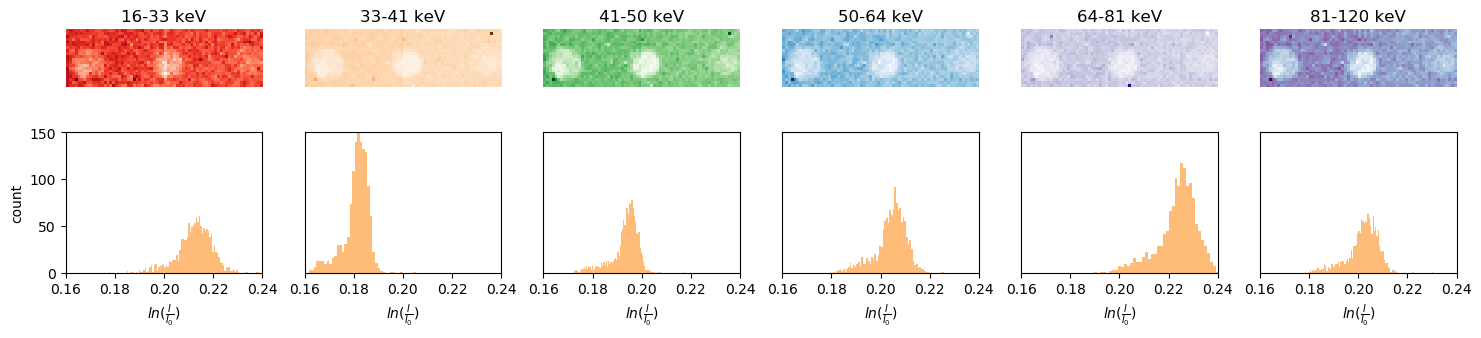

In [158]:
images_dir = '../../clustering_figures/'

cmaps = ['BuPu','Purples','Blues','Greens','Oranges','Reds']
ebins = ['16-33 keV','33-41 keV','41-50 keV','50-64 keV','64-81 keV','81-120 keV']
plt.figure(figsize=[7.4*2,1.85*2])
cs = []

for ii,cm in zip(range(0,6),cmaps):
    
    plt.subplot(2,6,6-ii)
    plt.title(ebins[5 - ii])
    plt.imshow(np.reshape(M[:,ii], (20,68), order="F"),cmap=cm)
    plt.axis('off')
    plt.subplot(2,6,12-ii)
    plt.hist(M[:,ii],bins=100,color= colourblind(6))#'#fc4f30')#
    if ii == 5:
        plt.ylim([0,150])
        plt.xlim([0.16,0.24])        
        plt.ylabel('count')
    else:
        plt.ylim([0,150])
        plt.xlim([0.16,0.24])
        plt.yticks([])
    plt.xlabel(r'$ln(\frac{I}{I_0})$')
    
plt.tight_layout()
plt.savefig(images_dir+'poly_figure2.png',dpi=300)

In [199]:
import os, shutil
import itertools
import imageio

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy import linalg

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.decomposition import NMF, FastICA, PCA
from sklearn.metrics import homogeneity_score,homogeneity_completeness_v_measure
from sklearn import mixture
from skimage.restoration import inpaint
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans


import scipy.ndimage as ndimage
import scipy.spatial as spatial
import scipy.misc as misc
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Ellipse

class I_gmm:
    def __init__(self):
        self.XY = None
        
    def plot_cov(self,means, covariances,ct):
        if ct == 'spherical':
            return
        color_iter = itertools.cycle([
                                  '#008fd5','#fc4f30'])
        ax =plt.gca()
        for i, (mean, covar, color) in enumerate(zip(
                means, covariances, color_iter)):
                
            v, w = linalg.eigh(covar)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            alpha = 0.3

            alpha = 0.2
            
            for kk in range(0,10):
                ell = Ellipse(mean, v[0]*0.1*(kk+1), v[1]*0.1*(kk+1), 180. + angle, color=color)
                ell.set_clip_box(ax.bbox)
                ell.set_alpha(alpha)
                ax.add_artist(ell)                   
#             multi_normal = multivariate_normal(mean[0:2],u[0:2])
#             ax.contour(np.sort(X[:,0]),np.sort(X[:,1]),
#                    multi_normal.pdf(self.XY).reshape(X.shape[0],X.shape[0]),
#                    colors='black',alpha=0.3)
            ax.scatter(mean[0],mean[1],marker='x',c=color,zorder=10,s=150,edgecolor='k')        
        
    def iterative_gmm(self,dataset = 'bb',fake = True,mode = 'gmm',binary = False,im_dir = './images/',savegif = False,title ='temp',bic_thresh = 0,maxiter = 40,nc =5,v_and_1 = False,thresh = 0.9,cov=[],n_components=2,covt='spherical',ra=False,pca = True):

        '''
        dataset: string
        The filename of the material something like 'bb','pp'
        fake: bool
        Whether or not the data is fake, if it is not it will be cropped
        mode: str
        'fraction' will reduce the input to a combination of the relative signals
        e.g. bin1 - bin0/sum
        binary: bool
        Whether or not to show the output as binary or not
        nc: int
        pca components
        '''
        
        np.random.seed(10)

        # Clear the imagedir
        if savegif:
            folder = im_dir
            for the_file in os.listdir(folder):
                file_path = os.path.join(folder, the_file)
                try:
                    if os.path.isfile(file_path):
                        os.unlink(file_path)
                    #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                except Exception as e:
                    print(e)
        if ra:
            arrowsU = []
            arrowsV = []        
        bic0 = np.infty
        itern = 0
        inds = [2,3,4]
        label_true = loadmat('2'+dataset+'_mask')['BW'] 
        X1 = loadmat('all'+dataset)['Z'][:,inds]

        if not fake:
            X1 = X1[400:,:].copy()
            label_true = label_true[400:].copy()
            length = 48
        else:
            length = 68

        # This is code for just looking at the ratio of the bins
        if mode == 'fraction':
            # initialize vector for fraction
            X2 = np.zeros([X1.shape[0],int(scipy.special.comb(5,2))])
            result = [x for x in itertools.combinations(np.arange(5),2)]
            for jj in range(0,X2.shape[1]):
                r2 = np.reshape(abs(X1[:,result[jj][0]] - X1[:,result[jj][1]])/abs(X1[:,result[jj][0]] + X1[:,result[jj][1]]), (20,length), order="F")
                X2[:,jj] = np.reshape(gaussian_filter1d(r2,sigma=1),20*length,order="F")
            ind = np.argsort(np.mean(X1,0))
        #     X1 = X2[:,ind[:4]]
        else:
            for jj in range(0,X1.shape[1]):
                r2 = np.reshape(X1[:,jj], (20,length), order="F")
                X1[:,jj] = np.reshape(gaussian_filter1d(r2,sigma=1),20*length,order="F")
        ct = 'full'
        if mode == 'bgmm':
            bgmm = mixture.BayesianGaussianMixture(
                    n_components=n_components, covariance_type=covt)
        elif mode == 'kmeans':
            km = KMeans(n_clusters=n_components)
        
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=covt)
        gmm1 = mixture.GaussianMixture(n_components=n_components,
                                  covariance_type='full')

        ims = []
        
        pca = True
        # Do the PCA decomposition
        if pca:
            X1 = PCA(n_components=nc).fit_transform(X1)
        
        X3 = X1[:,0:2].copy()
        
        fig = plt.figure(figsize=(10,10))
        bics = []        
        for ii in range(0,maxiter):

            X = X1.copy()

            if mode == 'gmm':
                y_pred = gmm.fit_predict(X)
            elif mode == 'bgmm':
                y_pred = bgmm.fit_predict(X)
                y_ff = gmm.fit(X)
            elif mode == 'kmeans':
                y_pred = km.fit_predict(X)
                y_ff = gmm.fit(X)
            
            y_ff1 = gmm1.fit(X)
            
            # if I should show the vmeasure
            if v_and_1:

                homo1,comp1,vs1 = homogeneity_completeness_v_measure(
                    label_true.squeeze(), y_pred)

                bic = gmm.aic(X)
                bic1 = gmm1.aic(X)
                print(vs1,itern,bic,bic1)
            else:
                bic = gmm.aic(X)
                print(bic)

            # Stop if bic is lower
            if bic - bic0 < bic_thresh:
                bic0 = bic
            else:
                print('BIC got higher')
                break                
            print(bic)
            
            # map the bad values to zero
            for kk in range(n_components):
                temp = X[y_pred == kk,:]

                if cov == 'robust':
                    robust_cov = MinCovDet().fit(temp)
                else:
                    robust_cov = EmpiricalCovariance().fit(temp)
                
                # Calculating the mahal distances
                robust_mahal = robust_cov.mahalanobis(
                    temp - robust_cov.location_) ** (0.33)
                
                if thresh < 1:
                    temp[robust_mahal > robust_mahal.max()*thresh] = 0
                else:
#                     import pdb; pdb.set_trace()
                    temp[robust_mahal > np.sort(robust_mahal)[-thresh]] = 0
                    
                X[y_pred == kk,:] = temp

            mask_one = X[:,1] == 0

            if y_pred[3] == 0:
                # Map top to zero if it is the wrong combo
                y_pred = y_pred + 1
                y_pred[y_pred == n_components] = 0

            m_reshape = np.reshape(mask_one, (20,length), order="F")

            if itern == 0:
                y_0 = y_pred
            
            # Plotting functions

            ax0 = fig.add_subplot(111)

            a = -(y_pred - label_true.squeeze())
            y_reshape = np.reshape(a, (20,length), order="F")
            
            colorz = ['#fc4f30','#008fd5']
            
            for ii,cc in zip(range(0,2),colorz):
                temp = X1[y_pred == ii,:]
                ax0.scatter(temp[:,0],temp[:,1],c=cc,edgecolor='k')

            ax0.set_title('New Method')
            self.plot_cov(gmm1.means_, gmm1.covariances_,ct='full')
            plt.xlabel('Principal Component One')
            plt.ylabel('Principal Component Two')
            plt.ylim([-0.01,0.01])
            plt.title('GMM Example Using PTFE')
            

#             if itern == 0:
#                 axes = plt.gca()
#                 ylim = axes.get_ylim()
#                 xlim = axes.get_xlim() 

#             ax0.set_xlim(xlim)
#             ax0.set_ylim(ylim)
            
#             ax0.scatter(X3[:,0],X3[:,1],c='k',alpha = 0.1)

        if ra:
            return arrowsU,arrowsV
    def find_paws(self,data, smooth_radius = 1, threshold = 0.0001):
        # https://stackoverflow.com/questions/4087919/how-can-i-improve-my-paw-detection
        """Detects and isolates contiguous regions in the input array"""
        # Blur the input data a bit so the paws have a continous footprint 
        data = ndimage.uniform_filter(data, smooth_radius)
        # Threshold the blurred data (this needs to be a bit > 0 due to the blur)
        thresh = data > threshold
        # Fill any interior holes in the paws to get cleaner regions...
        filled = ndimage.morphology.binary_fill_holes(thresh)
        # Label each contiguous paw
        coded_paws, num_paws = ndimage.label(filled)
        # Isolate the extent of each paw
        # find_objects returns a list of 2-tuples: (slice(...), slice(...))
        # which represents a rectangular box around the object
        data_slices = ndimage.find_objects(coded_paws)
        return data_slices

    def animate(self,frame,im = None):
        """Detects paws and animates the position and raw data of each frame
        in the input file"""
        # With matplotlib, it's much, much faster to just update the properties
        # of a display object than it is to create a new one, so we'll just update
        # the data and position of the same objects throughout this animation...

        # Since we're making an animation with matplotlib, we need 
        # ion() instead of show()...
        fig = plt.gcf()
        ax = plt.axes([.25, .55, .6, .4], facecolor='y')
        plt.axis('off')

        # Make an image based on the first frame that we'll update later
        # (The first frame is never actually displayed)
        if im is None:
            plt.imshow(frame,cmap='brg')
        else:
            plt.imshow(im)
        plt.title('Image Space')

        # Make 4 rectangles that we can later move to the position of each paw
        rects = [Rectangle((0,0), 1,1, fc='none', ec='red') for i in range(4)]
        [ax.add_patch(rect) for rect in rects]


        # Process and display each frame

        paw_slices = self.find_paws(frame)

        # Hide any rectangles that might be visible
        [rect.set_visible(False) for rect in rects]

        # Set the position and size of a rectangle for each paw and display it
        for slice, rect in zip(paw_slices, rects):
            dy, dx = slice
            rect.set_xy((dx.start, dy.start))
            rect.set_width(dx.stop - dx.start + 1)
            rect.set_height(dy.stop - dy.start + 1)
            rect.set_visible(True)


-20060.133292560546
-20060.133292560546


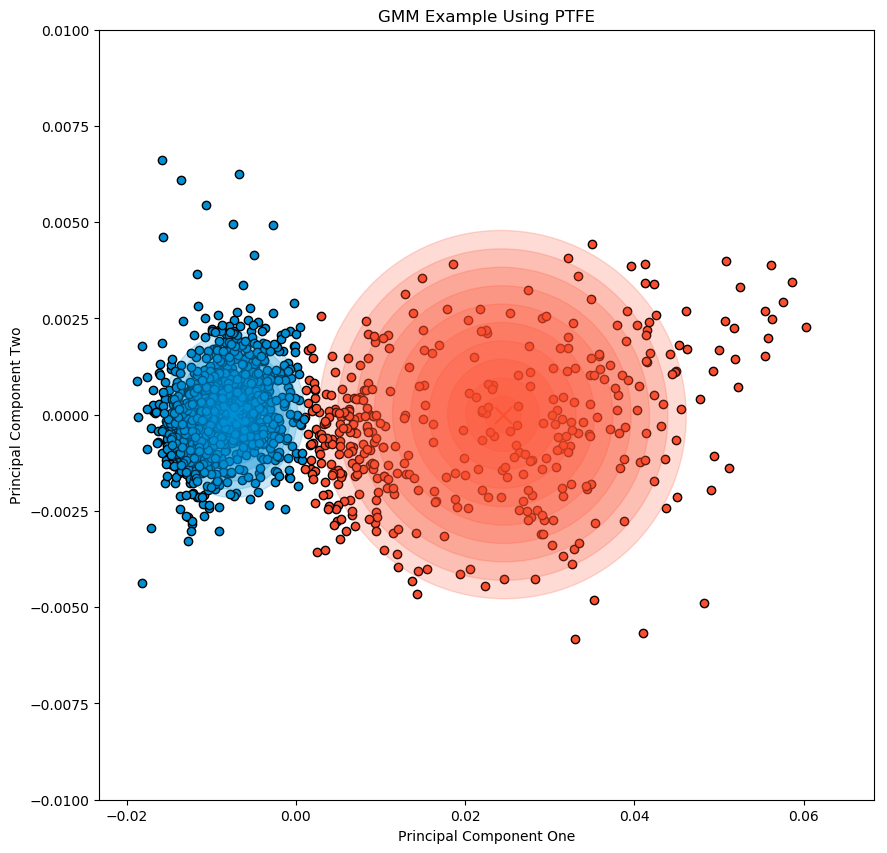

In [200]:
plt.style.use('default')
I = I_gmm()
arrowsU,arrowV = I.iterative_gmm(dataset='ptfe',savegif=True,title='01_good_run',
                binary=True,mode='bgmm',nc = 2,v_and_1=False,
                n_components=2,maxiter=1,thresh=0.8,ra = True)
plt.savefig(images_dir+'GMM.png',dpi=300)

In [201]:
import os, shutil
import itertools
import imageio

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy import linalg

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.decomposition import NMF, FastICA, PCA
from sklearn.metrics import homogeneity_score,homogeneity_completeness_v_measure
from sklearn import mixture
from skimage.restoration import inpaint
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans


import scipy.ndimage as ndimage
import scipy.spatial as spatial
import scipy.misc as misc
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Ellipse

class I_gmm:
    def __init__(self):
        self.XY = None
        
    def plot_cov(self,means, covariances,ct):
        if ct == 'spherical':
            return
        color_iter = itertools.cycle([
                                  '#008fd5','#fc4f30'])
        ax =plt.gca()
        for i, (mean, covar, color) in enumerate(zip(
                means, covariances, color_iter)):
                
            v, w = linalg.eigh(covar)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])
            
            v[0] = 0.015
            v[1] = 0.015

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            alpha = 0.2
            
            for kk in range(0,10):
                ell = Ellipse(mean, v[0]*0.1*(kk+1), v[1]*0.1*(kk+1), 180. + angle, color=color)
                ell.set_clip_box(ax.bbox)
                ell.set_alpha(alpha)
                ax.add_artist(ell)        
            
#             multi_normal = multivariate_normal(mean[0:2],u[0:2])
#             ax.contour(np.sort(X[:,0]),np.sort(X[:,1]),
#                    multi_normal.pdf(self.XY).reshape(X.shape[0],X.shape[0]),
#                    colors='black',alpha=0.3)
            ax.scatter(mean[0],mean[1],marker='x',c=color,zorder=10,s=150)        
        
    def iterative_gmm(self,dataset = 'bb',fake = True,mode = 'gmm',binary = False,im_dir = './images/',savegif = False,title ='temp',bic_thresh = 0,maxiter = 40,nc =5,v_and_1 = False,thresh = 0.9,cov=[],n_components=2,covt='spherical',ra=False,pca = True):

        '''
        dataset: string
        The filename of the material something like 'bb','pp'
        fake: bool
        Whether or not the data is fake, if it is not it will be cropped
        mode: str
        'fraction' will reduce the input to a combination of the relative signals
        e.g. bin1 - bin0/sum
        binary: bool
        Whether or not to show the output as binary or not
        nc: int
        pca components
        '''
        np.random.seed(10)
        # Clear the imagedir
        if savegif:
            folder = im_dir
            for the_file in os.listdir(folder):
                file_path = os.path.join(folder, the_file)
                try:
                    if os.path.isfile(file_path):
                        os.unlink(file_path)
                    #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                except Exception as e:
                    print(e)
        if ra:
            arrowsU = []
            arrowsV = []        
        bic0 = np.infty
        itern = 0
        inds = [2,3,4]
        label_true = loadmat('2'+dataset+'_mask')['BW'] 
        X1 = loadmat('all'+dataset)['Z'][:,inds]

        if not fake:
            X1 = X1[400:,:].copy()
            label_true = label_true[400:].copy()
            length = 48
        else:
            length = 68

        # This is code for just looking at the ratio of the bins
        if mode == 'fraction':
            # initialize vector for fraction
            X2 = np.zeros([X1.shape[0],int(scipy.special.comb(5,2))])
            result = [x for x in itertools.combinations(np.arange(5),2)]
            for jj in range(0,X2.shape[1]):
                r2 = np.reshape(abs(X1[:,result[jj][0]] - X1[:,result[jj][1]])/abs(X1[:,result[jj][0]] + X1[:,result[jj][1]]), (20,length), order="F")
                X2[:,jj] = np.reshape(gaussian_filter1d(r2,sigma=1),20*length,order="F")
            ind = np.argsort(np.mean(X1,0))
        #     X1 = X2[:,ind[:4]]
        else:
            for jj in range(0,X1.shape[1]):
                r2 = np.reshape(X1[:,jj], (20,length), order="F")
                X1[:,jj] = np.reshape(gaussian_filter1d(r2,sigma=1),20*length,order="F")
        ct = 'full'
        if mode == 'bgmm':
            bgmm = mixture.BayesianGaussianMixture(
                    n_components=n_components, covariance_type=covt)
        elif mode == 'kmeans':
            km = KMeans(n_clusters=n_components)
        
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=covt)
        gmm1 = mixture.GaussianMixture(n_components=n_components,
                                  covariance_type='full')

        ims = []
        
        pca = True
        # Do the PCA decomposition
        if pca:
            X1 = PCA(n_components=nc).fit_transform(X1)
        
        X3 = X1[:,0:2].copy()
        
        fig = plt.figure(figsize=(10,10))
        bics = []        
        for ii in range(0,maxiter):

            X = X1.copy()

            if mode == 'gmm':
                y_pred = gmm.fit_predict(X)
            elif mode == 'bgmm':
                y_pred = bgmm.fit_predict(X)
                y_ff = gmm.fit(X)
            elif mode == 'kmeans':
                y_pred = km.fit_predict(X)
                y_ff = gmm.fit(X)
                
            
            y_ff1 = gmm1.fit(X)
            
            # if I should show the vmeasure
            if v_and_1:

                homo1,comp1,vs1 = homogeneity_completeness_v_measure(
                    label_true.squeeze(), y_pred)

                bic = gmm.aic(X)
                bic1 = gmm1.aic(X)
                print(vs1,itern,bic,bic1)
            else:
                bic = gmm.aic(X)
                print(bic)

            # Stop if bic is lower
            if bic - bic0 < bic_thresh:
                bic0 = bic
            else:
                print('BIC got higher')
                break                
            print(bic)
            
            # map the bad values to zero
            for kk in range(n_components):
                temp = X[y_pred == kk,:]

                if cov == 'robust':
                    robust_cov = MinCovDet().fit(temp)
                else:
                    robust_cov = EmpiricalCovariance().fit(temp)
                
                # Calculating the mahal distances
                robust_mahal = robust_cov.mahalanobis(
                    temp - robust_cov.location_) ** (0.33)
                
                if thresh < 1:
                    temp[robust_mahal > robust_mahal.max()*thresh] = 0
                else:
#                     import pdb; pdb.set_trace()
                    temp[robust_mahal > np.sort(robust_mahal)[-thresh]] = 0
                    
                X[y_pred == kk,:] = temp

            mask_one = X[:,1] == 0

            if y_pred[3] == 0:
                # Map top to zero if it is the wrong combo
                y_pred = y_pred + 1
                y_pred[y_pred == n_components] = 0

            m_reshape = np.reshape(mask_one, (20,length), order="F")

            if itern == 0:
                y_0 = y_pred
            
            # Plotting functions

            ax0 = fig.add_subplot(111)

            a = -(y_pred - label_true.squeeze())
            y_reshape = np.reshape(a, (20,length), order="F")
            
            colorz = ['#fc4f30','#008fd5']

            for ii,cc in zip(range(0,2),colorz):
                temp = X1[y_pred == ii,:]
                ax0.scatter(temp[:,0],temp[:,1],c=cc,edgecolor='k')

            ax0.set_title('New Method')
            self.plot_cov(km.cluster_centers_, gmm1.covariances_,ct='full')
            plt.xlabel('Principal Component One')
            plt.ylabel('Principal Component Two')
            plt.ylim([-0.01,0.01])
            plt.title('K-Means Example Using PTFE')
            

#             if itern == 0:
#                 axes = plt.gca()
#                 ylim = axes.get_ylim()
#                 xlim = axes.get_xlim() 

#             ax0.set_xlim(xlim)
#             ax0.set_ylim(ylim)
            
#             ax0.scatter(X3[:,0],X3[:,1],c='k',alpha = 0.1)

        if ra:
            return arrowsU,arrowsV
    def find_paws(self,data, smooth_radius = 1, threshold = 0.0001):
        # https://stackoverflow.com/questions/4087919/how-can-i-improve-my-paw-detection
        """Detects and isolates contiguous regions in the input array"""
        # Blur the input data a bit so the paws have a continous footprint 
        data = ndimage.uniform_filter(data, smooth_radius)
        # Threshold the blurred data (this needs to be a bit > 0 due to the blur)
        thresh = data > threshold
        # Fill any interior holes in the paws to get cleaner regions...
        filled = ndimage.morphology.binary_fill_holes(thresh)
        # Label each contiguous paw
        coded_paws, num_paws = ndimage.label(filled)
        # Isolate the extent of each paw
        # find_objects returns a list of 2-tuples: (slice(...), slice(...))
        # which represents a rectangular box around the object
        data_slices = ndimage.find_objects(coded_paws)
        return data_slices

    def animate(self,frame,im = None):
        """Detects paws and animates the position and raw data of each frame
        in the input file"""
        # With matplotlib, it's much, much faster to just update the properties
        # of a display object than it is to create a new one, so we'll just update
        # the data and position of the same objects throughout this animation...

        # Since we're making an animation with matplotlib, we need 
        # ion() instead of show()...
        fig = plt.gcf()
        ax = plt.axes([.25, .55, .6, .4], facecolor='y')
        plt.axis('off')

        # Make an image based on the first frame that we'll update later
        # (The first frame is never actually displayed)
        if im is None:
            plt.imshow(frame,cmap='brg')
        else:
            plt.imshow(im)
        plt.title('Image Space')

        # Make 4 rectangles that we can later move to the position of each paw
        rects = [Rectangle((0,0), 1,1, fc='none', ec='red') for i in range(4)]
        [ax.add_patch(rect) for rect in rects]


        # Process and display each frame

        paw_slices = self.find_paws(frame)

        # Hide any rectangles that might be visible
        [rect.set_visible(False) for rect in rects]

        # Set the position and size of a rectangle for each paw and display it
        for slice, rect in zip(paw_slices, rects):
            dy, dx = slice
            rect.set_xy((dx.start, dy.start))
            rect.set_width(dx.stop - dx.start + 1)
            rect.set_height(dy.stop - dy.start + 1)
            rect.set_visible(True)


-20060.133292560546
-20060.133292560546


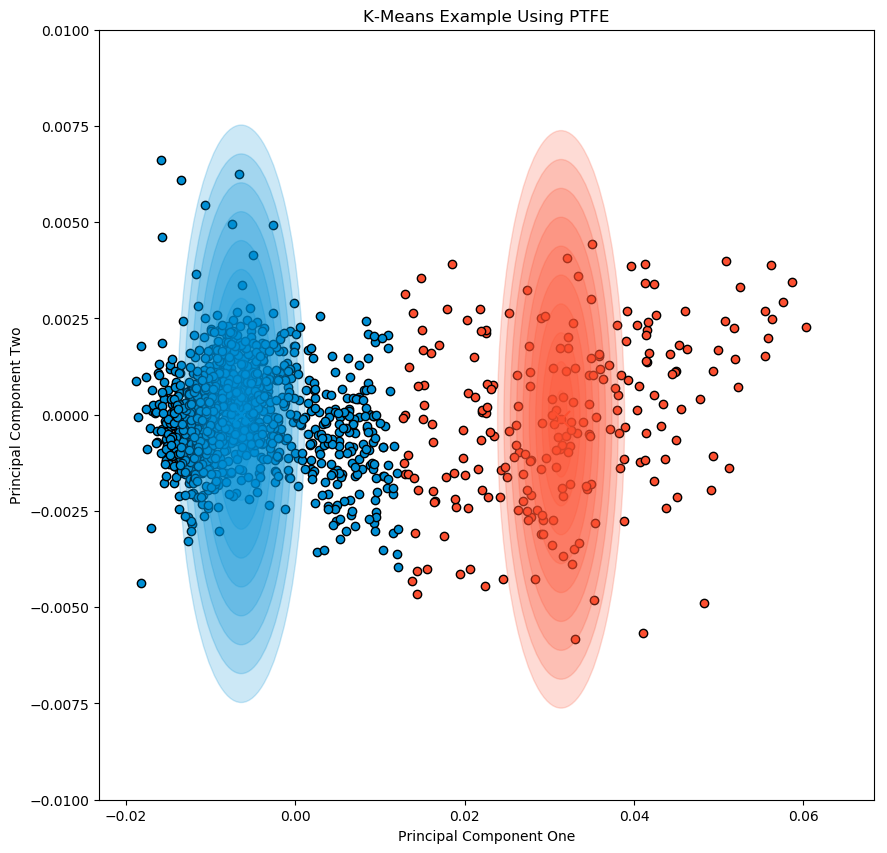

In [202]:
plt.style.use('default')
I = I_gmm()
arrowsU,arrowV = I.iterative_gmm(dataset='ptfe',savegif=True,title='01_good_run',
                binary=True,mode='kmeans',nc = 2,v_and_1=False,
                n_components=2,maxiter=1,thresh=0.8,ra = True)
plt.savefig(images_dir+'Kmeans.png',dpi=300)

In [109]:
X = []
X.append(FastICA(n_components=2).fit_transform(M))
X.append(PCA(n_components=2).fit_transform(M))
X.append(NMF(n_components=2).fit_transform(M))

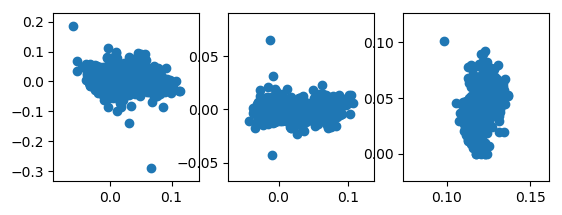

In [7]:
plt.figure()

for ii in range(0,3):
    plt.subplot(2,3,ii+1)
    plt.scatter(X[ii][:,0],X[ii][:,1])

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm', 'mat', 'linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
images_dir = '../../clustering_figures/'
plt.style.use('default')
mat = 'bb'
M = loadmat('all'+mat+'.mat')['Z'][:,:]

X = []
X.append(FastICA(n_components=2).fit_transform(M))
X.append(PCA(n_components=2).fit_transform(M))
X.append(NMF(n_components=2).fit_transform(M))

In [20]:
X[0] = scaler.fit_transform(X[0])
X[1] = scaler.fit_transform(X[1])
X[2] = scaler.fit_transform(X[2])

In [ ]:
theta = np.pi/4
rotmat = np.asarray([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

X[2] = np.matmul(X[2],rotmat)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


[0.00036227 0.00112502]
-0.14185060356437867 0.10834630367671019 -0.12761156499778437 0.302122289649412
1142


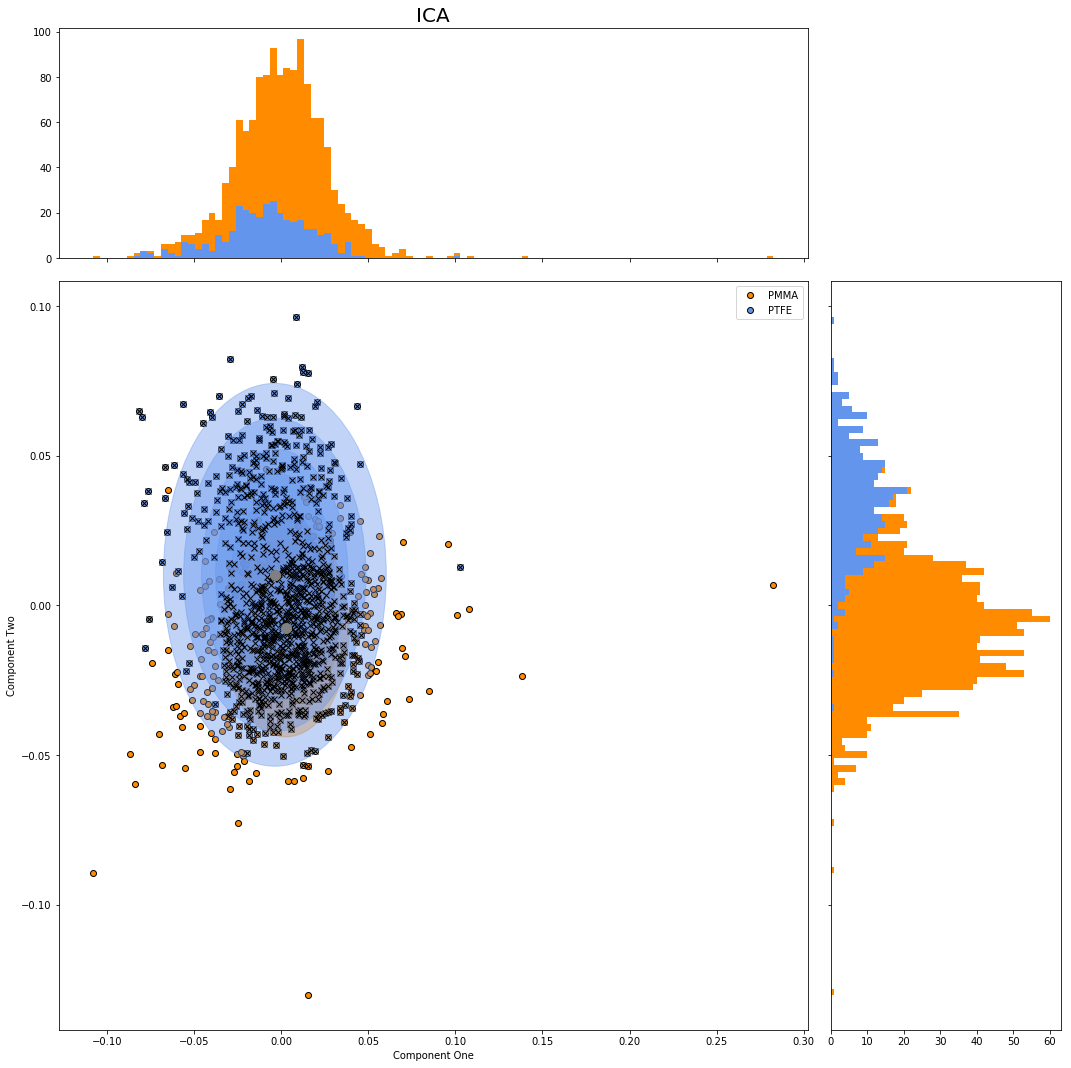

[4.99133585e-05 4.46387535e-05]
-0.026178589391513553 0.05626006209286529 -0.051897034978536274 0.06984772768244799
100


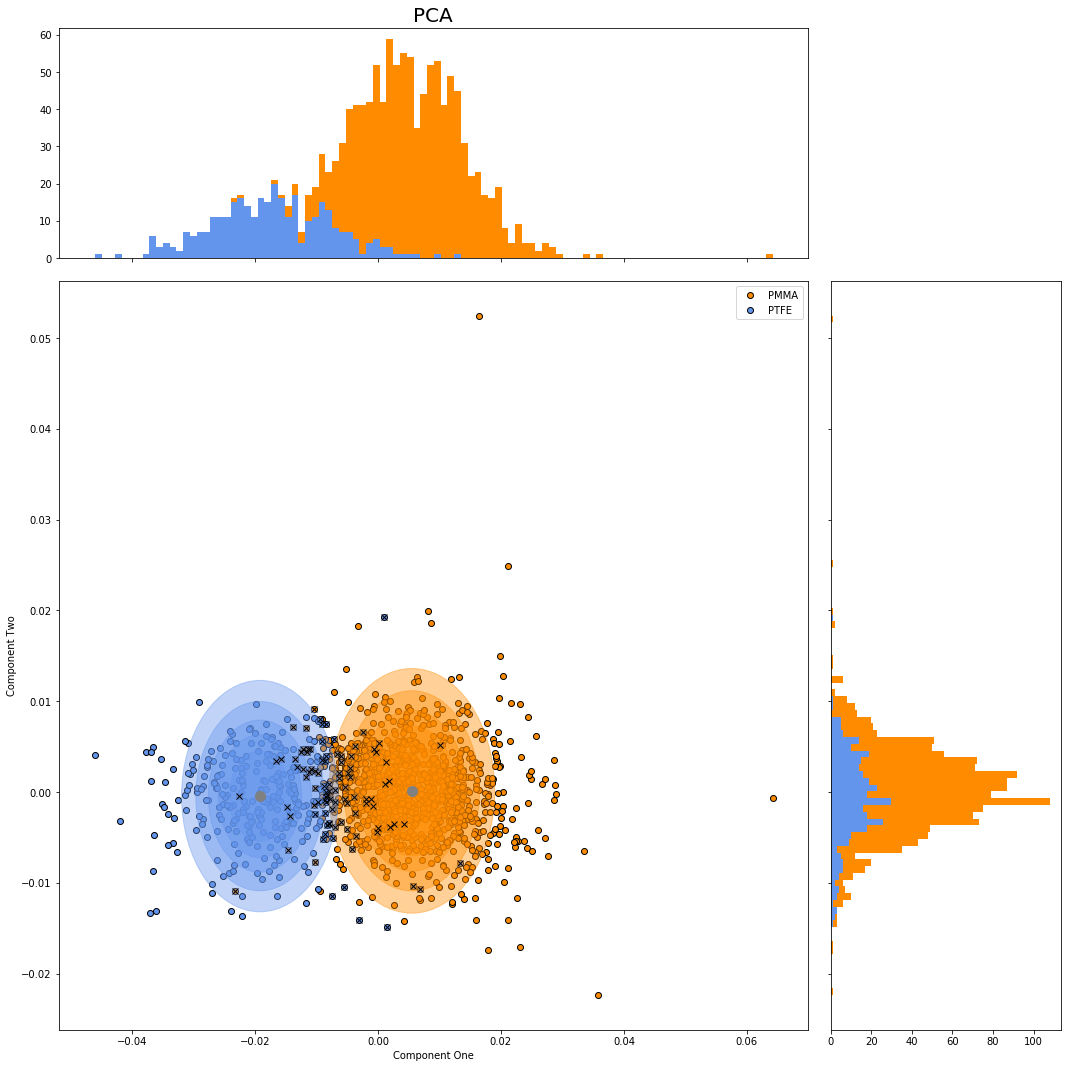

[2.55278957e-05 2.14784284e-05]
-0.005658976172365538 0.10878790399459173 0.1013476846957218 0.1303591536679163
775


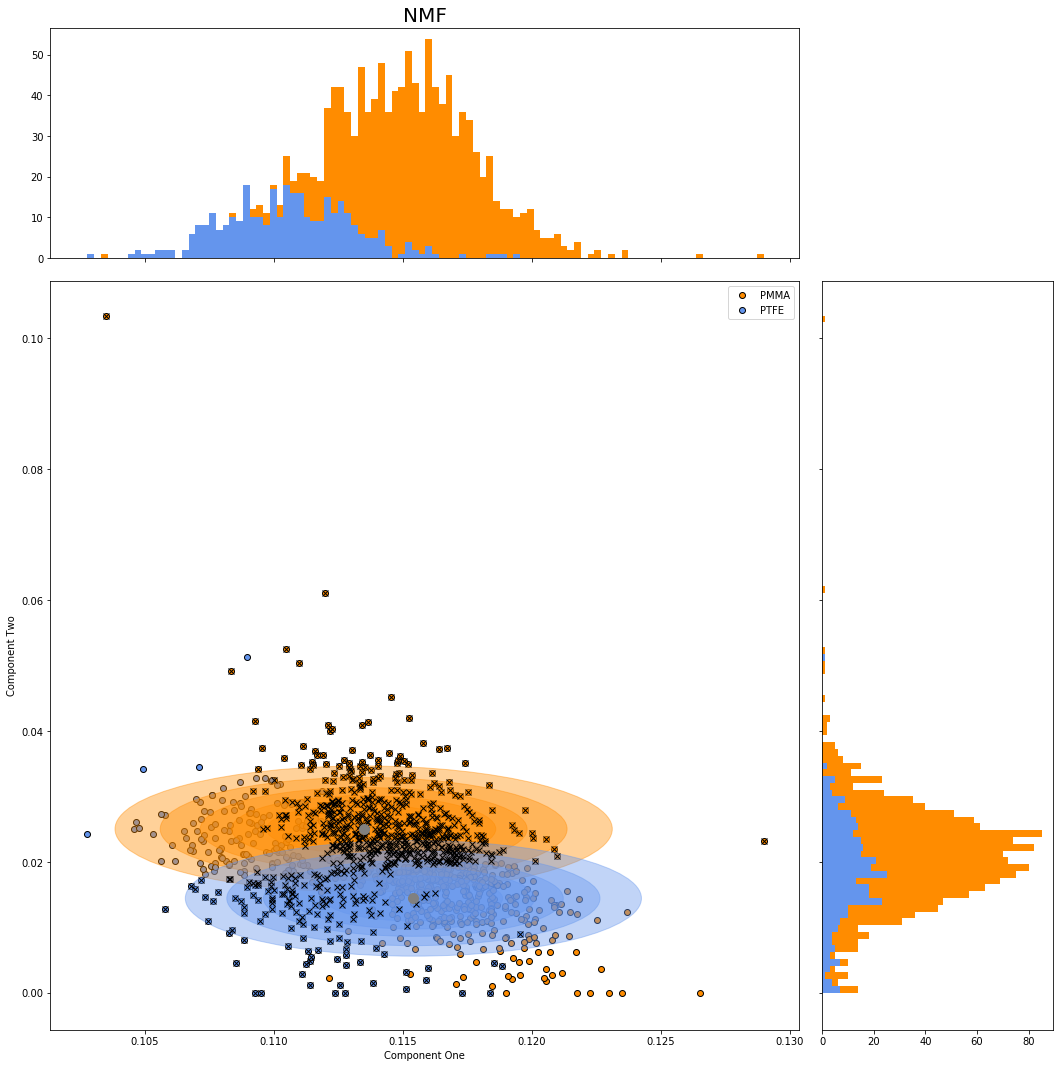

<Figure size 432x288 with 0 Axes>

In [51]:
labels_true = loadmat('2'+mat+'_mask.mat')['BW']
lab = np.reshape(labels_true, (20*68), order="F")

ttls = ['ICA','PCA','NMF']
cmaps = ['BuPu','Purples','Blues','Greens','Oranges','Reds']
ebins = ['16-33 keV','33-41 keV','41-50 keV','50-64 keV','64-81 keV','81-120 keV']
# plt.figure(figsize=[7.4*2,1.85*2])
cs = []
method = 'full'
np.random.seed(999)

for ii,cm in zip(range(0,3),cmaps):
    
#     plt.subplot(2,3,ii+1)
#     plt.title(ebins[5 - ii])
#     plt.scatter(X[ii][:,0],X[ii][:,1])
#     plt.axis('off')
    plot_hists(X[ii][:,0],X[ii][:,1],X[ii],ii+1,lab,ttls[ii])
#     if ii == 5:
#         plt.ylim([0,150])
#         plt.xlim([0.16,0.24])        
#         plt.ylabel('count')
#     else:
#         plt.ylim([0,150])
#         plt.xlim([0.16,0.24])
#         plt.yticks([])
#     plt.xlabel(r'$ln(\frac{I}{I_0})$')
    
plt.tight_layout()

In [22]:
import scipy.ndimage as ndimage
import scipy.spatial as spatial
import scipy.misc as misc
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Ellipse
from scipy import linalg


def plot_hists(x,y,X,n,lab,ttl,load_file=False):

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

#     # start with a rectangular Figure
    plt.figure(figsize=(2*8,2*8))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    axHistx.set_title(ttl,size=20)
    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    
    colorz = ['darkorange','cornflowerblue']
    lbls = ['PMMA','PTFE']
    
    ct = 'spherical'
    
    gmm = mixture.BayesianGaussianMixture(n_components=2,
                                      covariance_type=ct)
    
    y_pred = gmm.fit_predict(X)
    
    plot_cov(gmm.means_, gmm.covariances_,axScatter,ct=ct)
    
    # the scatter plot:
    for ii,cc in zip([0,1],colorz):
        axScatter.scatter(x[lab == ii], y[lab == ii],c=cc,edgecolor='k',label=lbls[ii])
    axScatter.set_xlabel('Component One')
    axScatter.set_ylabel('Component Two')
    axScatter.legend()
    
    ymin,ymax,xmin,xmax = -0.026178589391513553, 0.05626006209286529, -0.051897034978536274, 0.06984772768244799,

    
    axScatter.set_ylim(ymin,ymax)
    axScatter.set_ylim(xmin,xmax)  
    
    if y_pred[3] == 0:
        # Map top to zero if it is the wrong combo
        y_pred = y_pred + 1
        y_pred[y_pred == 2] = 0
        
    a = -(y_pred - lab)

    axScatter.plot(x[a == 0], y[a == 0],'kx')
    print(sum(a == 0))
        
    
    # now determine nice limits by hand:
    binwidth = 0.01
#     xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
#     lim = (int(xymax/binwidth) + 1) * binwidth

#     axScatter.set_xlim((-lim, lim))
#     axScatter.set_ylim((-lim, lim))

#     bins = np.arange(-lim, lim + binwidth, binwidth)

    b0 = axHistx.hist(x,bins=100,color='darkorange')[1]
    b1 = axHisty.hist(y,bins=100, orientation='horizontal',color='darkorange')[1]
    
    axHistx.hist(x[lab == ii],b0,color='cornflowerblue')
    axHisty.hist(y[lab == ii],b1,color='cornflowerblue', orientation='horizontal')
    
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    images_dir = '../../clustering_figures/'

    plt.savefig((images_dir+ttl+'goodafterfull'+'.png'),dpi=300,format='png') # 'test' replace with ct
    plt.show()

    

In [ ]:
theta = np.pi/4
rotmat = np.asarray([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

X[2] = np.matmul(X[2],rotmat)

In [12]:
>>> import numpy as np
>>> from sklearn.preprocessing import PowerTransformer, StandardScaler
>>> pt = PowerTransformer()
>>> data = [[1, 2], [3, 2], [4, 5]]
>>> print(pt.fit(X[2]))
>>> print(pt.lambdas_)
>>> X[2] = pt.transform(X[2])


PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
[-82.38083085 -26.0611261 ]


In [21]:
import itertools
from scipy import linalg

def plot_cov(means, covariances,ax,ct = 'full'):

    color_iter = itertools.cycle([
                              'darkorange','cornflowerblue'])
    print(covariances)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        
        if ct == 'spherical':
            covar2 = [[covar,-covar],[-covar,covar]]
            v, w = linalg.eigh(covar2)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])
            v[0] = v[1]
        else:
            v, w = linalg.eigh(covar)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])

#         v[0] = 0.015
#         v[1] = 0.015

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        alpha = 0.4
        
        nums = [0.56,0.76,.94,1.17,1.43]
        
        for kk in range(0,len(nums)):
            ell = Ellipse(mean, v[0]*nums[kk]/1.5, v[1]*nums[kk]/1.5, 180. + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha)
            ax.add_artist(ell)   

#             multi_normal = multivariate_normal(mean[0:2],u[0:2])
#             ax.contour(np.sort(X[:,0]),np.sort(X[:,1]),
#                    multi_normal.pdf(self.XY).reshape(X.shape[0],X.shape[0]),
#                    colors='black',alpha=0.3)
        ax.scatter(mean[0],mean[1],c='grey',zorder=10,s=100)   

In [251]:
def compare_2(bars_se,bars_pc,title='all',leg=['Single Energy','Spectral'],algo=True):
    cinds=[0,2,3,4,7,8,9,10]

    ms = []
    two_means = []
    ward =[]
    spectral = []
    dbscan = []
    average_linkage = []
    affinity_propagation = []
    birch = []
    gmm = []
    bgmm = []
    hdb = []

    cinds_all = (
        ('KMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('HDBSCAN', hdb),
        ('GaussianMixture', gmm),
        ('BGaussianMixture', bgmm)
    )
    plt.figure()
    clustering_algorithms = [cinds_all[j] for j in cinds]
    
    if algo:
        
        bars_se2 = np.mean(np.asarray(bars_se),axis=0)
        bars_pc2 = np.mean(np.asarray(bars_pc),axis=0)

        indeces = np.argsort(bars_pc2)

        bars_se2 = bars_se2[indeces]

        bars_pc2.sort()
    else:
        bars_se2 = np.asarray(bars_se)
        bars_pc2 = np.asarray(bars_pc)     

    # vs = np.asarray(vs)
    bars = []
    colors = []
    n_components_range = range(len(bars_pc2))
    # cv_types = [item[1] for item in datasets2]


    # color_iter = cycle(['navy', 'turquoise', 'cornflowerblue',
    #                               'darkorange','k'])
    # # Plot the BIC scores
    # plt.figure(figsize=(8, 6))
    # plt.rcParams['axes.facecolor'] = (1,1,1)            
    # spl = plt.subplot(1, 1, 1)

    # for i, (cv_type, pcolor) in enumerate(zip(cv_types, color_iter)):
    #     xpos = np.array(n_components_range) + 0.166 * (i - 2)
    #     bars.append( vs[i * len(n_components_range):
    #                                   (i + 1) * len(n_components_range)])

    # # import ipdb; ipdb.set_trace()
    [colors.append(colourblind(col)) for col in n_components_range]

    # bars2 = np.mean(np.asarray(bars),axis=0)

    # indeces = np.argsort(bars2)
    # #         import ipdb; ipdb.set_trace()
    # bars2.sort()
    # bars2 = np.concatenate(bars_se2,bars_de2,bars_pc2)
    datasets2 = (('glass','Glass'),('pp','Poly'),('bb','Bluebelt'),('ptfe','PTFE'),('steel','Steel'
            ),('PMMA','PMMA'))
    
    if algo:
        clustering_algorithms = [clustering_algorithms[i] for i in indeces]
    

    plt.bar(range(1,len(bars_pc2)*3,3),bars_se2,color='cornflowerblue')
    plt.bar(range(2,len(bars_pc2)*3,3),bars_pc2,color='darkorange')
    if algo:
        plt.xticks(range(1,len(bars_pc2)*3,3),[item[0] for item in clustering_algorithms],rotation = 45, ha="right")
        plt.xlabel('Algorithm')
        plt.ylabel('V-score')
    else:
        plt.xticks(range(1,len(bars_pc2)*3,3),[item[1] for item in datasets2],rotation = 45, ha="right")
        plt.xlabel('Material')
        plt.ylabel('Weight of Component')        
    plt.xticks()
    if algo:
        plt.ylim([0, 1])
    plt.title('Mixture Weights for Two Components')
    # xpos = np.mod(vs.argmax(), len(n_components_range)) + .65 +\
    #     .16 * np.floor(vs.argmax() / len(n_components_range))
    # plt.text(xpos, vs.min() * 0.97 + .03 * vs.max(), '*', fontsize=14)

    plt.legend(leg,loc=1)  
    plt.tight_layout()
    images_dir = '../../clustering_figures/'
    plt.savefig(images_dir + '{}.png'.format(title),dpi=300)

In [252]:
aic_2 = plot_results(0,0,0,1,cinds=[10],dinds=[0,1,2,3,4,5],return_weights=True,out=False,rng=4508)

In [253]:
weight_0 = np.asarray(aic_2)[:,0]
weight_1 = np.asarray(aic_2)[:,1]
compare_2(weight_0,weight_1,title='weights',leg=['$1^{st}$ Component','$2^{nd}$ Component'],algo=False)

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


FigureCanvasNbAgg()

In [255]:
aic_2 = plot_results(0,0,0,1,cinds=[9],dinds=[0,1,2,3,4,5],return_AIC=True,out=False,algo_params={})
aic_1 = plot_results(0,0,0,1,cinds=[9],dinds=[0,1,2,3,4,5],algo_params={'n_clusters': 1},return_AIC=True,out=False)

In [256]:
def compare_2(bars_se,bars_pc,title='all',leg=['Single Energy','Spectral'],algo=True):
    cinds=[0,2,3,4,7,8,9,10]

    ms = []
    two_means = []
    ward =[]
    spectral = []
    dbscan = []
    average_linkage = []
    affinity_propagation = []
    birch = []
    gmm = []
    bgmm = []
    hdb = []

    cinds_all = (
        ('KMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('HDBSCAN', hdb),
        ('GaussianMixture', gmm),
        ('BGaussianMixture', bgmm)
    )
    plt.figure()
    clustering_algorithms = [cinds_all[j] for j in cinds]
    
    if algo:
        
        bars_se2 = np.mean(np.asarray(bars_se),axis=0)
        bars_pc2 = np.mean(np.asarray(bars_pc),axis=0)

        indeces = np.argsort(bars_pc2)

        bars_se2 = bars_se2[indeces]

        bars_pc2.sort()
    else:
        bars_se2 = np.asarray(bars_se)
        bars_pc2 = np.asarray(bars_pc)     

    # vs = np.asarray(vs)
    bars = []
    colors = []
    n_components_range = range(len(bars_pc2))
    # cv_types = [item[1] for item in datasets2]


    # color_iter = cycle(['navy', 'turquoise', 'cornflowerblue',
    #                               'darkorange','k'])
    # # Plot the BIC scores
    # plt.figure(figsize=(8, 6))
    # plt.rcParams['axes.facecolor'] = (1,1,1)            
    # spl = plt.subplot(1, 1, 1)

    # for i, (cv_type, pcolor) in enumerate(zip(cv_types, color_iter)):
    #     xpos = np.array(n_components_range) + 0.166 * (i - 2)
    #     bars.append( vs[i * len(n_components_range):
    #                                   (i + 1) * len(n_components_range)])

    # # import ipdb; ipdb.set_trace()
    [colors.append(colourblind(col)) for col in n_components_range]

    # bars2 = np.mean(np.asarray(bars),axis=0)

    # indeces = np.argsort(bars2)
    # #         import ipdb; ipdb.set_trace()
    # bars2.sort()
    # bars2 = np.concatenate(bars_se2,bars_de2,bars_pc2)
    datasets2 = (('glass','Glass'),('pp','Poly'),('bb','Bluebelt'),('ptfe','PTFE'),('steel','Steel'
            ),('PMMA','PMMA'))
    
    if algo:
        clustering_algorithms = [clustering_algorithms[i] for i in indeces]
    

    plt.bar(range(1,len(bars_pc2)*3,3),bars_se2,color='cornflowerblue')
    plt.bar(range(2,len(bars_pc2)*3,3),bars_pc2,color='darkorange')
    if algo:
        plt.xticks(range(1,len(bars_pc2)*3,3),[item[0] for item in clustering_algorithms],rotation = 45, ha="right")
        plt.xlabel('Algorithm')
        plt.ylabel('V-score')
    else:
        plt.xticks(range(1,len(bars_pc2)*3,3),[item[1] for item in datasets2],rotation = 45, ha="right")
        plt.xlabel('Material')
        plt.ylabel('AIC')        
    plt.xticks()
    if algo:
        plt.ylim([0, 1])
    plt.title(title)
    # xpos = np.mod(vs.argmax(), len(n_components_range)) + .65 +\
    #     .16 * np.floor(vs.argmax() / len(n_components_range))
    # plt.text(xpos, vs.min() * 0.97 + .03 * vs.max(), '*', fontsize=14)

    plt.legend(leg,loc=1)  
    plt.tight_layout()
    images_dir = '../../clustering_figures/'
    plt.savefig(images_dir + '{}.png'.format(title),dpi=300)

In [257]:
compare_2(aic_2,aic_1,title='AIC for 1 and 2 clusters',leg=['2 Clusters','1 Cluster'],algo=False)

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


FigureCanvasNbAgg()

In [228]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

FigureCanvasNbAgg()

In [ ]:
0.56,0.76,.94,1.17,1.43

In [25]:
import os, shutil
import itertools
import imageio

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy import linalg

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.decomposition import NMF, FastICA, PCA
from sklearn.metrics import homogeneity_score,homogeneity_completeness_v_measure
from sklearn import mixture
from skimage.restoration import inpaint
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans


import scipy.ndimage as ndimage
import scipy.spatial as spatial
import scipy.misc as misc
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Ellipse

class I_gmm:
    def __init__(self):
        self.XY = None
        
    def plot_cov(self,means, covariances,ct):
        if ct == 'spherical':
            return
        color_iter = itertools.cycle(['navy', 'navy', 'cornflowerblue', 'gold',
                                  'darkorange'])
        ax =plt.gca()
        for i, (mean, covar, color) in enumerate(zip(
                means, covariances, color_iter)):
                
            v, w = linalg.eigh(covar)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            alpha = 0.2
            ell = Ellipse(mean, v[0], v[1], 180. + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha)
            ax.add_artist(ell)
            ell = Ellipse(mean, v[0]*4, v[1]*2, 180. + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha)
            ell = Ellipse(mean, v[0]*2, v[1]*2, 180. + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha)
            ax.add_artist(ell)            
#             multi_normal = multivariate_normal(mean[0:2],u[0:2])
#             ax.contour(np.sort(X[:,0]),np.sort(X[:,1]),
#                    multi_normal.pdf(self.XY).reshape(X.shape[0],X.shape[0]),
#                    colors='black',alpha=0.3)
            ax.scatter(mean[0],mean[1],c='grey',zorder=10,s=100)        
        
    def iterative_gmm(self,dataset = 'bb',fake = True,mode = 'gmm',binary = False,im_dir = './images/',savegif = False,title ='temp',bic_thresh = 0,maxiter = 40,nc =5,v_and_1 = False,thresh = 0.9,cov=[],n_components=2,covt='spherical',ra=False,pca = True):

        '''
        dataset: string
        The filename of the material something like 'bb','pp'
        fake: bool
        Whether or not the data is fake, if it is not it will be cropped
        mode: str
        'fraction' will reduce the input to a combination of the relative signals
        e.g. bin1 - bin0/sum
        binary: bool
        Whether or not to show the output as binary or not
        nc: int
        pca components
        '''
        # Clear the imagedir
        if savegif:
            folder = im_dir
            for the_file in os.listdir(folder):
                file_path = os.path.join(folder, the_file)
                try:
                    if os.path.isfile(file_path):
                        os.unlink(file_path)
                    #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                except Exception as e:
                    print(e)
        if ra:
            arrowsU = []
            arrowsV = []        
        bic0 = np.infty
        itern = 0
        inds = [2,3,4]
        label_true = loadmat('2'+dataset+'_mask')['BW'] 
        X1 = loadmat('all'+dataset)['Z'][:,inds]

        if not fake:
            X1 = X1[400:,:].copy()
            label_true = label_true[400:].copy()
            length = 48
        else:
            length = 68

        # This is code for just looking at the ratio of the bins
        if mode == 'fraction':
            # initialize vector for fraction
            X2 = np.zeros([X1.shape[0],int(scipy.special.comb(5,2))])
            result = [x for x in itertools.combinations(np.arange(5),2)]
            for jj in range(0,X2.shape[1]):
                r2 = np.reshape(abs(X1[:,result[jj][0]] - X1[:,result[jj][1]])/abs(X1[:,result[jj][0]] + X1[:,result[jj][1]]), (20,length), order="F")
                X2[:,jj] = np.reshape(gaussian_filter1d(r2,sigma=1),20*length,order="F")
            ind = np.argsort(np.mean(X1,0))
        #     X1 = X2[:,ind[:4]]
        else:
            for jj in range(0,X1.shape[1]):
                r2 = np.reshape(X1[:,jj], (20,length), order="F")
                X1[:,jj] = np.reshape(gaussian_filter1d(r2,sigma=1),20*length,order="F")
        ct = 'full'
        if mode == 'bgmm':
            bgmm = mixture.BayesianGaussianMixture(
                    n_components=n_components, covariance_type=covt)
        elif mode == 'kmeans':
            km = KMeans(n_clusters=n_components)
        
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=covt)
        gmm1 = mixture.GaussianMixture(n_components=n_components,
                                  covariance_type='full')

        ims = []
        
        pca = True
        # Do the PCA decomposition
        if pca:
            X1 = PCA(n_components=nc).fit_transform(X1)
        
        X3 = X1[:,0:2].copy()
        
        fig = plt.figure(figsize=(10,10))
        bics = []        
        for ii in range(0,maxiter):

            X = X1.copy()

            if mode == 'gmm':
                y_pred = gmm.fit_predict(X)
            elif mode == 'bgmm':
                y_pred = bgmm.fit_predict(X)
                y_ff = gmm.fit(X)
            elif mode == 'kmeans':
                y_pred = km.fit_predict(X)
                y_ff = gmm.fit(X)
            
            y_ff1 = gmm1.fit(X)
            
            # if I should show the vmeasure
            if v_and_1:

                homo1,comp1,vs1 = homogeneity_completeness_v_measure(
                    label_true.squeeze(), y_pred)

                bic = gmm.aic(X)
                bic1 = gmm1.aic(X)
                print(vs1,itern,bic,bic1)
            else:
                bic = gmm.aic(X)
                print(bic)

            # Stop if bic is lower
            if bic - bic0 < bic_thresh:
                bic0 = bic
            else:
                print('BIC got higher')
                break                
            print(bic)
            
            # map the bad values to zero
            for kk in range(n_components):
                temp = X[y_pred == kk,:]

                if cov == 'robust':
                    robust_cov = MinCovDet().fit(temp)
                else:
                    robust_cov = EmpiricalCovariance().fit(temp)
                
                # Calculating the mahal distances
                robust_mahal = robust_cov.mahalanobis(
                    temp - robust_cov.location_) ** (0.33)
                
                if thresh < 1:
                    temp[robust_mahal > robust_mahal.max()*thresh] = 0
                else:
#                     import pdb; pdb.set_trace()
                    temp[robust_mahal > np.sort(robust_mahal)[-thresh]] = 0
                    
                X[y_pred == kk,:] = temp

            mask_one = X[:,1] == 0

            if y_pred[3] == 0:
                # Map top to zero if it is the wrong combo
                y_pred = y_pred + 1
                y_pred[y_pred == n_components] = 0

            m_reshape = np.reshape(mask_one, (20,length), order="F")

            if itern == 0:
                y_0 = y_pred
            
            # Plotting functions

            ax0 = fig.add_subplot(111)

            a = -(y_pred - label_true.squeeze())
            y_reshape = np.reshape(a, (20,length), order="F")
            
            colorz = ['b','r','g','m']
            for jj,color in zip(range(a.min(),a.max()+1),colorz):
                print(jj)
                b = a == jj
                b = [i for i, x in enumerate(b) if x]
                if jj == 0:
                    c = b
                ax0.scatter(X1[b,0],X1[b,1],c=colorz[(jj-a.min())])

            ax0.set_title('New Method')
            self.plot_cov(gmm1.means_, gmm1.covariances_,ct='full')

            if itern == 0:
                axes = plt.gca()
                ylim = axes.get_ylim()
                xlim = axes.get_xlim() 

            ax0.set_xlim(xlim)
            ax0.set_ylim(ylim)
            
            ax0.scatter(X3[:,0],X3[:,1],c='k',alpha = 0.1)
            plt.text(.5*xlim[-1], ylim[0] + .005,'bad pts = {}'.format(format(len(c),"03")))     
            ax3 = plt.axes([.22, .15, .15, .1])
            bics.append(bic)
            plt.plot(bics)
            plt.yticks([])
            plt.xlabel('iteration')
            plt.ylabel('BIC')
            ax2 = plt.axes([.25, .55, .6, .4], facecolor='y')

            if binary:
                plt.imshow(y_reshape,cmap='brg')
            else:
                plt.imshow(np.reshape(X1[:,0], (20,length), order="F"))

            plt.title('Image Space')
            plt.xticks([])
            plt.yticks([])

            if savegif:
                plt.savefig(im_dir + '{}.png'.format(format(itern, "02")))
                
            itern += 1
            
            i, j = np.where(m_reshape == True)

#             if binary:
#                 plt.imshow(y_reshape,cmap='brg')
#             else:
            plt.scatter(j,i,marker='x',c='k')
            
#             import pdb; pdb.set_trace()
            d = [i for i, x in enumerate(mask_one) if x]
            ax0.scatter(X1[d,0],X1[d,1],marker='x',c='k')
   
                
            if savegif:
                plt.savefig(im_dir + '{}.png'.format(format(itern, "02")))
            
            itern += 1
            
            X2 = X1.copy()
            # Inpainting the zeros
            r2 = np.reshape(X1, (20,length,X1.shape[1]), order="F")
            X1 = np.reshape(inpaint.inpaint_biharmonic(
                r2,m_reshape,multichannel=True),
                            (20*length,X1.shape[1]),order="F")
            
            ax0.plot([X2[d,0],X1[d,0]],[X2[d,1],X1[d,1]],'r')
            
            if ra:
                arrowsU.append([X2[d,0],X1[d,0]])
                arrowsV.append([X2[d,1],X1[d,1]])
            
            
            if binary:
                plt.imshow(y_reshape,cmap='brg')
            else:
                plt.imshow(np.reshape(X1[:,0], (20,length), order="F"))
            
            if savegif:
                plt.savefig(im_dir + '{}.png'.format(format(itern, "02")))
                plt.clf()
            
            

    #         X_old = X.copy()
    #             np.save('bb',y_reshape)

        #     plt.figure()
        #     robust_mahal1.sort()
        #     plt.plot(robust_mahal1)
        #     plt.plot(250,robust_mahal1.max()*.87,'r*')
        #     plt.savefig('./images2/{}.png'.format(format(itern, "02")))  

        #     plt.figure()
        #     robust_mahal2.sort()
        #     plt.plot(robust_mahal2)
        #     plt.plot(250,robust_mahal2.max()*.87,'r*')
        #     plt.savefig('./images3/{}.png'.format(format(itern, "02")))  
            itern += 1

        fig = plt.figure(figsize=(10,10))
        ax0 = fig.add_subplot(111)  

        colorz = ['b','r','g','m']
        for jj,color in zip(range(a.min(),a.max()+1),colorz):
            print(jj)
            b = a == jj
            b = [i for i, x in enumerate(b) if x]
            if jj == 0:
                c = b
            ax0.scatter(X1[b,0],X1[b,1],c=colorz[(jj-a.min())])
            
        self.plot_cov(gmm1.means_, gmm1.covariances_,ct)
        ax0.scatter(X3[:,0],X3[:,1],c='k',alpha = 0.1)

        ax0.set_title('New Method')
        ax0.set_xlim(xlim)
        ax0.set_ylim(ylim)
        plt.text(.5*xlim[-1], ylim[0] + .005,'bad pts = {}'.format(format(len(c),"03")))      
        
        r = np.reshape(y_pred, (20,length), order="F")
        if binary:
            self.animate(y_reshape)
        else:
            self.animate(y_reshape, im=np.reshape(X1[:,0], (20,length), order="F"))
        ax3 = plt.axes([.22, .15, .15, .1])
        bics.append(bic)
        plt.plot(bics)
        plt.yticks([])
        plt.xlabel('iteration')
        plt.ylabel('BIC')
        plt.savefig(im_dir + '{}.png'.format(format(itern, "02")))


        plt.figure()
        plt.imshow(r)
        plt.xticks([])
        plt.yticks([])  
        plt.figure()

        r0 = np.reshape(y_0, (20,length), order="F")
        plt.imshow(r - r0)
        plt.xticks([])
        plt.yticks([])  
        
        ttls = ['ICA','PCA','NMF']
        ll = 1
        np.random.seed(999)


        plot_hists(X1[:,0],X1[:,1],X1[:,[0,1]],ll+1,lab,ttls[ll])

        if savegif:
            # save gif
            files = os.listdir('./images')
            images = []
            for filename in files:
                images.append(imageio.imread('./images/'+filename))
            imageio.mimsave(title + '.mp4', images,fps=1)
            imageio.mimsave(title + '.gif', images)


        if ra:
            return r
    def find_paws(self,data, smooth_radius = 1, threshold = 0.0001):
        # https://stackoverflow.com/questions/4087919/how-can-i-improve-my-paw-detection
        """Detects and isolates contiguous regions in the input array"""
        # Blur the input data a bit so the paws have a continous footprint 
        data = ndimage.uniform_filter(data, smooth_radius)
        # Threshold the blurred data (this needs to be a bit > 0 due to the blur)
        thresh = data > threshold
        # Fill any interior holes in the paws to get cleaner regions...
        filled = ndimage.morphology.binary_fill_holes(thresh)
        # Label each contiguous paw
        coded_paws, num_paws = ndimage.label(filled)
        # Isolate the extent of each paw
        # find_objects returns a list of 2-tuples: (slice(...), slice(...))
        # which represents a rectangular box around the object
        data_slices = ndimage.find_objects(coded_paws)
        return data_slices

    def animate(self,frame,im = None):
        """Detects paws and animates the position and raw data of each frame
        in the input file"""
        # With matplotlib, it's much, much faster to just update the properties
        # of a display object than it is to create a new one, so we'll just update
        # the data and position of the same objects throughout this animation...

        # Since we're making an animation with matplotlib, we need 
        # ion() instead of show()...
        fig = plt.gcf()
        ax = plt.axes([.21, .56, .6, .4], facecolor='y')
        plt.axis('off')

        # Make an image based on the first frame that we'll update later
        # (The first frame is never actually displayed)
        if im is None:
            plt.imshow(frame,cmap='brg')
        else:
            plt.imshow(im)
        plt.title('Image Space')

        # Make 4 rectangles that we can later move to the position of each paw
        rects = [Rectangle((0,0), 1,1, fc='none', ec='red') for i in range(4)]
        [ax.add_patch(rect) for rect in rects]


        # Process and display each frame

        paw_slices = self.find_paws(frame)

        # Hide any rectangles that might be visible
        [rect.set_visible(False) for rect in rects]

        # Set the position and size of a rectangle for each paw and display it
        for slice, rect in zip(paw_slices, rects):
            dy, dx = slice
            rect.set_xy((dx.start, dy.start))
            rect.set_width(dx.stop - dx.start + 1)
            rect.set_height(dy.stop - dy.start + 1)
            rect.set_visible(True)


In [26]:
I = I_gmm()
%matplotlib inline

0.6951181743230227 0 -35284.75827384989 -38785.4376648551
-35284.75827384989
-1
0
1
0.6953211965117359 3 -35415.417942631844 -39058.60519778791
-35415.417942631844
-1
0
1
0.6976277797795727 6 -35519.69935666893 -39354.395656221546
-35519.69935666893
-1
0
1
0.6976277797795727 9 -35543.21409297654 -39449.387423078915
-35543.21409297654
-1
0
1
0.6976277797795727 12 -35552.08900743651 -39498.45133341956
-35552.08900743651
-1
0
1
0.6976277797795727 15 -35615.517204064 -39565.62606977775
-35615.517204064
-1
0
1
0.6976277797795727 18 -35652.89336796854 -39675.780746915334
-35652.89336796854
-1
0
1
0.7051055422610644 21 -35682.74791743291 -39735.98156437214
-35682.74791743291
-1
0
1
0.7051055422610644 24 -35691.9128162991 -39808.43258207398
-35691.9128162991
-1
0
1
0.7232613757083634 27 -35758.21789677901 -39961.53684822045
-35758.21789677901
-1
0
1
0.7273031255279013 30 -35768.18183598247 -39977.39508584383
-35768.18183598247
-1
0
1
0.731694912846744 33 -35782.883127028435 -39992.29391007754


<Figure size 720x720 with 0 Axes>

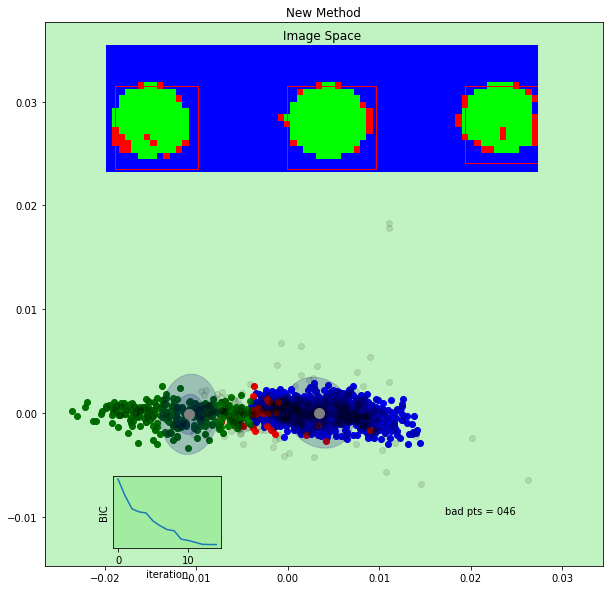

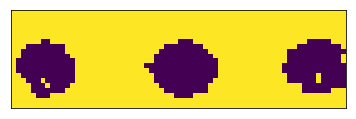

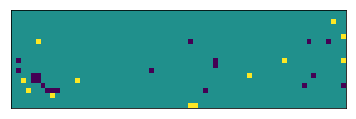

In [27]:
r = I.iterative_gmm(dataset='bb',savegif=True,title='01_good_run',
                binary=True,mode='bgmm',nc = 3,v_and_1=True,
                n_components=2,maxiter=20,thresh=0.9,ra = True)

# arrowsU,arrowV = I.iterative_gmm(dataset='bb',savegif=True,title='01_good_run',
# #                 binary=True,mode='bgmm',nc = 4,v_and_1=False,
# #                 n_components=2,maxiter=20,ra = True)

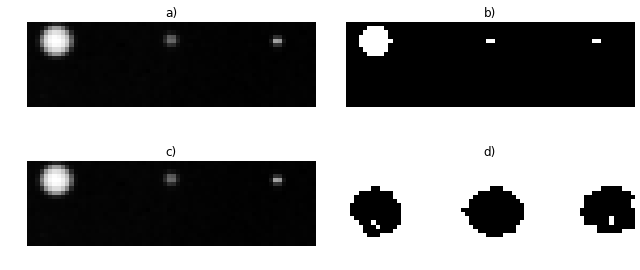

0.5732104926382094


In [36]:
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import exposure
from scipy.ndimage import gaussian_filter

labels_true = loadmat('2steel_mask.mat')['BW']
M = loadmat('allsteel.mat')['Z'][:,0]
camera = M
camera = np.reshape(camera,(20,68),order="F")
camera = gaussian_filter(camera,sigma=0.5)
val = filters.threshold_otsu(camera)

hist, bins_center = exposure.histogram(camera)

plt.figure(figsize=(9, 4))
plt.subplot(221)
plt.title('a)')
plt.imshow(camera, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(222)
plt.title('b)')
plt.imshow(-1*(camera < val), cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(223)
plt.title('c)')
plt.imshow(camera, cmap='gray', interpolation='nearest')
plt.axis('off')




plt.subplot(224)
plt.title('d)')
plt.imshow(r, cmap='gray', interpolation='nearest')
plt.axis('off')

# plt.subplot(133)
# plt.plot(bins_center, hist, lw=2)
# plt.axvline(val, color='k', ls='--')

plt.tight_layout()
plt.show()
#plt.savefig('../../clustering_figures/otsu.png')

homo1,comp1,vs1 = homogeneity_completeness_v_measure(
    labels_true.squeeze(), np.reshape(camera < val,(1360),order="F").squeeze())
print(vs1)

In [79]:
0.41 + 

(1360,)

BIC got higher


UnboundLocalError: local variable 'y_pred' referenced before assignment

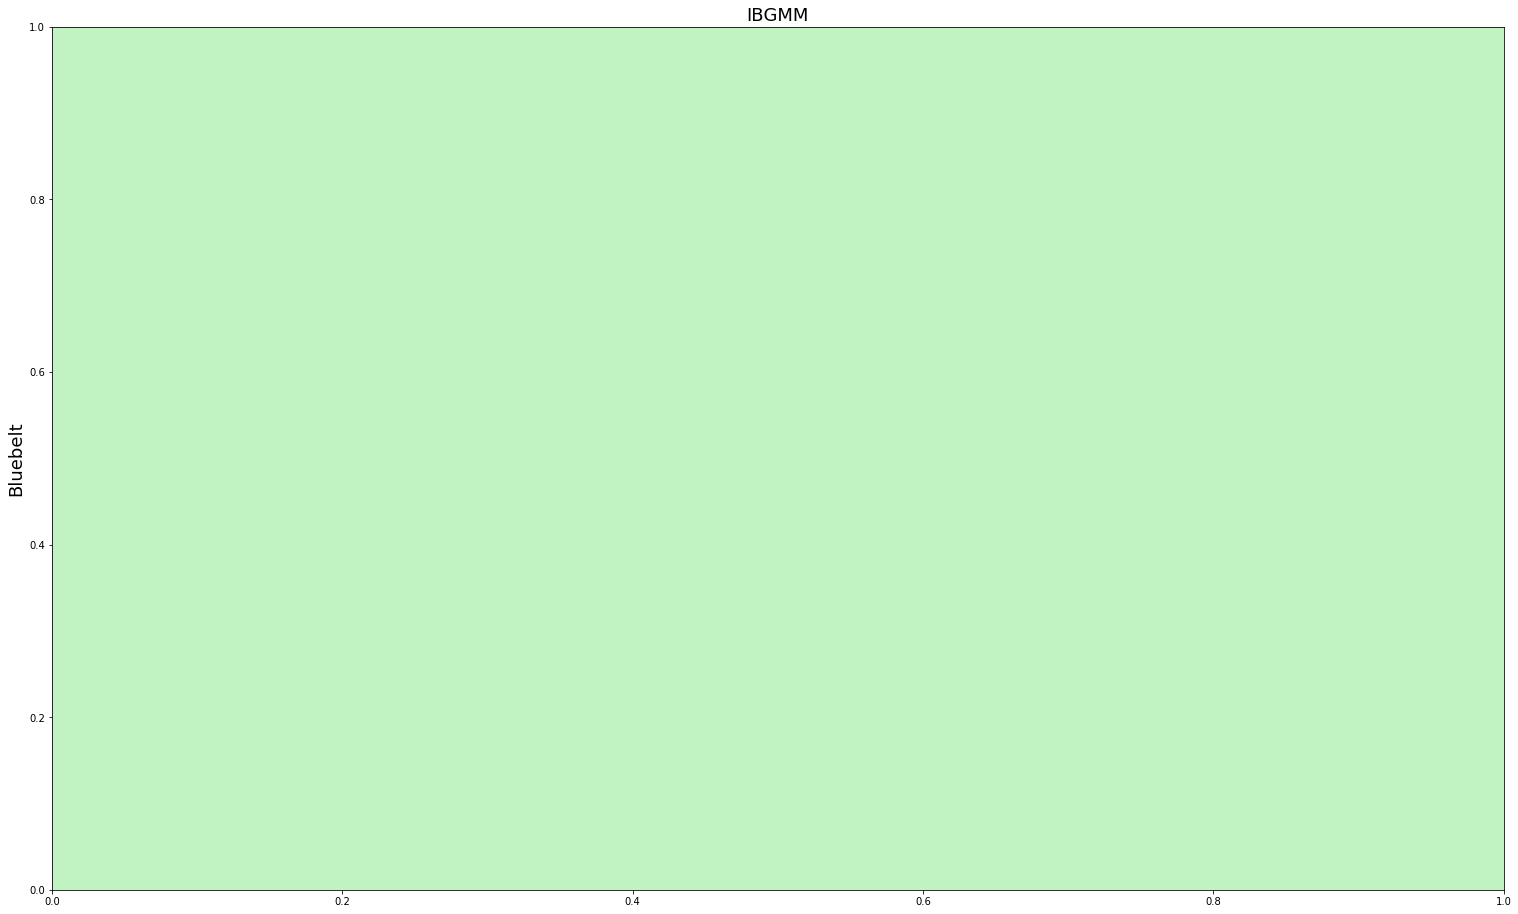

<Figure size 720x720 with 0 Axes>

In [16]:
plot_results(0,0,0,1,cinds=[11],dinds=[2])

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from clustering_comparison import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


BIC got higher
BIC got higher


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

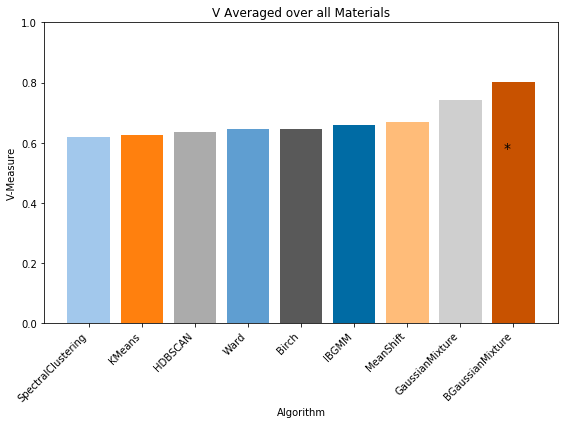

In [15]:
plot_results(0,0,0,1,cinds=[0,2,3,4,7,8,9,10,11],dinds=[0,4])

BIC got higher


<Figure size 720x720 with 0 Axes>

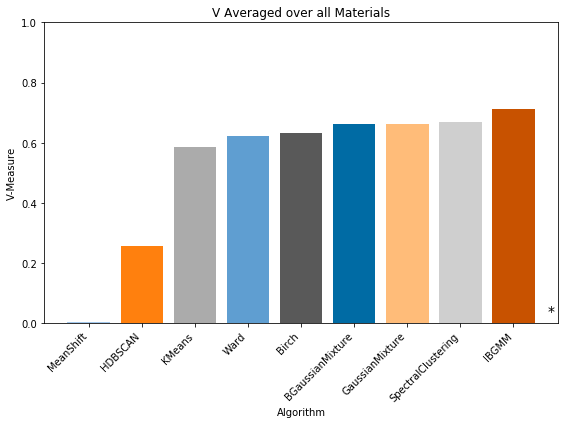

In [38]:
plot_results(0,0,0,1,cinds=[0,2,3,4,7,8,9,10,11],dinds=[2])